# CSCI153 Final Project: Neural Style Transfer
## Stephanie Fulcar & Elena Williams

In this project, we are recreating the style transfer algorithm delveloped by [Gatys et. al.](https://arxiv.org/pdf/1508.06576).

## Setup

In [1]:
%pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [46]:
# Standard Libraries
import numpy as np

# Model Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

import copy

# Visualization Libraries
from PIL import Image
import matplotlib.pyplot as plt

In [47]:
from tqdm import tqdm

In [48]:
# Check to see if we're running on the server GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## DataLoader

In [49]:
# Defining image size based on harware capacity
# set imsize to 128 if working w/ CPU
# can set to higher resolution if working on GPU
imsize = 128

# Creating loader that formats all our images to be the same size
loader = transforms.Compose([
    transforms.Resize([imsize, imsize]),
    transforms.ToTensor()
])
def image_loader(im_name):
    im = loader(Image.open(im_name)).unsqueeze(0)
    return im.to(device, torch.float)

The paper did not provide the image files they used, but I was able to find the Amsterdam photo on [Wikipedia](https://en.wikipedia.org/wiki/File:Tuebingen_Neckarfront.jpg) and Starry Night on [Wikimedia](https://commons.wikimedia.org/wiki/File:Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg).


In [50]:
style_im = image_loader("images/Starry_Night.jpg")
content_im = image_loader("images/Tuebingen_Neckarfront.jpg")

In [51]:
# Function to convert model output back to image format
def tensor_to_image(tensor):
    image = transforms.ToPILImage()(tensor.cpu().clone().squeeze(0))
    return image

## Model Components: Loss Functions & Optimizer
The style transfer model attempts to minimize two different loss functions at the same time, one for content and one for style. The content loss function is simply a mean squared error loss while the style loss function applies a Gram matrix to the image prior to applying a mean squared error loss.

Note: we initally tried to implement our loss functions without using target and target.detach but we ran into errors while trying to integrate our loss functions into the model. We used the [offical Pytorch Neural Style Transfer tutorial](https://docs.pytorch.org/docs/stable/generated/torch.Tensor.detach.html) as a guide on how to use targets and the detach functionality to get our implementation working properly.

In [52]:
# Content Loss Function
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, im):
        self.loss = F.mse_loss(im, self.target)
        return im

In [53]:
MAGNITUDE_RATIO = 5e-9

In [54]:
# Gram Matrix Implementation
def gram(input):
    dims = input.size()
    features = input.reshape(dims[0]*dims[1], dims[2]*dims[3])
    product = torch.mm(features, features.t())
    return product / (dims[0]*dims[1]*dims[2]*dims[3])

In [55]:
# FFT Implementation
def spectral_magnitude(features):
    # Compute 2D FFT
    fft = torch.fft.fft2(features, dim=(-2, -1)).to(device)

    magnitude = torch.abs(fft)
    return magnitude

In [56]:
from scipy import signal

ModuleNotFoundError: No module named 'scipy'

In [57]:
# Style Loss Function
class StyleLoss(nn.Module):

    def __init__(self, feature_map, fraction_gram = 1):
        super(StyleLoss, self).__init__()
        self.gram_matrix = gram(feature_map).detach()
        self.spectrum = spectral_magnitude(feature_map).detach()
        self.feature_map = feature_map.detach()
        self.f = fraction_gram

    def forward(self, input_features):
        gram_loss = F.mse_loss(gram(input_features), self.gram_matrix)
        spectrum_loss = F.mse_loss(spectral_magnitude(input_features), self.spectrum)
        similarity = F.mse_loss(input_features, self.feature_map)

        # Combine losses
        self.loss = self.f * gram_loss + (1-self.f) * MAGNITUDE_RATIO * (spectrum_loss - 100*similarity)
        return input_features

We could not find a reference in the paper for which optimizer to use, but in a blog post elsewhere the authors suggest using L-BFGS for the optimizer.

In [58]:
def get_optimizer(input_img):
    return optim.LBFGS([input_img.requires_grad_()])

## Model Setup

The paper builds their style transfer model on the VGG-19 architecture. The model documentation requires that we apply both a mean and a standard deviation normalization to the tensor inputs, so we include a normalization layer class below.

In [59]:
network = models.vgg19(pretrained=True).features.to(device).eval()

/Applications/Mu Editor.app/Contents/Resources/Python/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Applications/Mu Editor.app/Contents/Resources/Python/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
norm_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
norm_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).reshape(-1, 1, 1)
        self.std = torch.tensor(std).reshape(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

## Building Our Model

The paper identified the specific layers that correspond to the content and style representations. Those layers are listed below. We use those layers from VGG to build our style transfer model.

In [61]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [63]:
def get_losses(network, norm_mean, norm_std, style_img, content_img, content_layers=content_layers, style_layers=style_layers, fraction_gram=1):
    network = copy.deepcopy(network)

    # normalization module
    normalization = Normalization(norm_mean, norm_std).to(device)
    model = nn.Sequential(normalization)

    content_losses = []
    style_losses = []

    layerNames = {
        nn.Conv2d: "conv",
        nn.ReLU: "relu",
        nn.MaxPool2d: "pool",
        nn.BatchNorm2d: "bn"
    }

    i = 0
    for layer in network.children():
        for layerType in layerNames.keys():
            if isinstance(layer, layerType):
                name = layerNames[layerType] + "_" + str(i) # match the convention in paper
                if layerType == nn.Conv2d:
                    i += 1
                elif layerType == nn.ReLU:
                    layer = nn.ReLU(inplace=False)

        model.add_module(name, layer)

        if name in content_layers:
            content_loss = ContentLoss(model(content_img).detach())
            model.add_module("content", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            style_loss = StyleLoss(model(style_img).detach(), fraction_gram)
            model.add_module("style" + str(i), style_loss)
            style_losses.append(style_loss)


    c_s_indices = [isinstance(m, ContentLoss) or isinstance(m, StyleLoss) for m in model]
    lastIdx = len(c_s_indices) - list(reversed(c_s_indices)).index(True)
    model = model[:lastIdx]

    return model, style_losses, content_losses

We modified style_weight and content_weight by hand to determine which values created the best style transfer.

The loss weights originally used in the tutorial were style_weight=1000000 and content_weight=1, which we used as a starting point. We ended up raising the content_weight a bit. The tutorial also intialized the value num_steps=300 which we used as a starting point and ended up sticking with after trying out other values.

In [64]:
def run_style_transfer(network, norm_mean, norm_std, content_img, style_img, input_img, num_steps=300,
                       style_layers=style_layers, content_layers=content_layers, style_weight=1000000,
                       content_weight=2, fraction_gram=1):
    
    model, style_losses, content_losses = get_losses(network,
        norm_mean, norm_std, style_img, content_img,
        content_layers, style_layers, fraction_gram)

    optimizer = get_optimizer(input_img)


    for i in tqdm(range(num_steps)):
        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)

            style_loss = sum(sl.loss for sl in style_losses) * style_weight
            content_loss = sum(sl.loss for sl in content_losses) * content_weight
            loss = style_loss + content_loss
            loss.backward()
            return loss

        optimizer.step(closure)
    input_img.data.clamp_(0, 1)

    return input_img

## Testing Model On Different Artisitic Styles


Note: increase num_steps before running these cells!

### Style Image = Starry Night

(-0.5, 127.5, 127.5, -0.5)

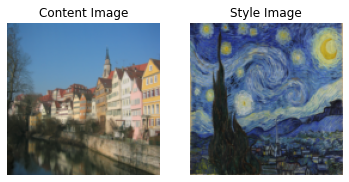

In [65]:
content_tensor = image_loader("images/Tuebingen_Neckarfront.jpg")
style_tensor = image_loader("images/Starry_Night.jpg")

content_img = tensor_to_image(content_tensor)
style_img = tensor_to_image(style_tensor)

input_tensor = content_tensor.clone()

plt.subplot(1,2,1)
plt.imshow(content_img)
plt.title('Content Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(style_img)
plt.title('Style Image')
plt.axis('off')

For only the Gram matrix loss, set fraction_gram to 1.

<ipython-input-60-21543b6a0e13>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).reshape(-1, 1, 1)
<ipython-input-60-21543b6a0e13>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).reshape(-1, 1, 1)
100%|██████████| 5/5 [01:02<00:00, 12.46s/it]


(-0.5, 127.5, 127.5, -0.5)

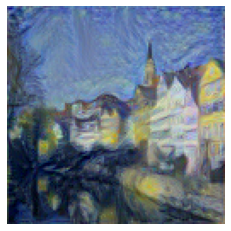

In [66]:
num_steps = 5
vg_output = run_style_transfer(network, norm_mean, norm_std, content_tensor, style_tensor,
                           input_tensor, num_steps=num_steps, style_layers=style_layers,
                           content_layers=content_layers, style_weight=200000, content_weight=2,
                               fraction_gram=1)

vg_output = tensor_to_image(vg_output)
plt.imshow(vg_output)
plt.axis('off')

You can also tune the parameters to get an intermediate value.

<ipython-input-39-21543b6a0e13>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).reshape(-1, 1, 1)
<ipython-input-39-21543b6a0e13>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).reshape(-1, 1, 1)
100%|██████████| 5/5 [00:56<00:00, 11.23s/it]


(-0.5, 127.5, 127.5, -0.5)

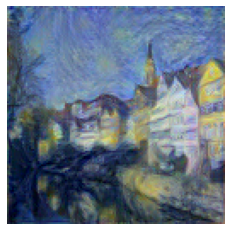

In [ ]:
num_steps = 5
vg_output = run_style_transfer(network, norm_mean, norm_std, content_tensor, style_tensor,
                           input_tensor, num_steps=num_steps, style_layers=style_layers,
                           content_layers=content_layers, style_weight=200000, content_weight=2,
                               fraction_gram=0.6)

vg_output = tensor_to_image(vg_output)
plt.imshow(vg_output)
plt.axis('off')

### Style Image = Picasso

(-0.5, 127.5, 127.5, -0.5)

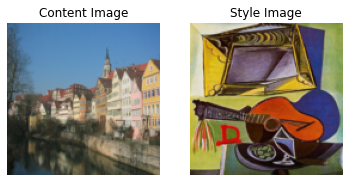

In [69]:
content_tensor = image_loader("images/Tuebingen_Neckarfront.jpg")
style_tensor = image_loader("images/picasso.jpg")

content_img = tensor_to_image(content_tensor)
style_img = tensor_to_image(style_tensor)

input_tensor = content_tensor.clone()

plt.subplot(1,2,1)
plt.imshow(content_img)
plt.title('Content Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(style_img)
plt.title('Style Image')
plt.axis('off')

In [70]:
num_steps = 5
pp_output = run_style_transfer(network, norm_mean, norm_std, content_tensor, style_tensor,
                           input_tensor, num_steps=num_steps, style_layers=style_layers,
                           content_layers=content_layers, style_weight=20000, content_weight=2)

<ipython-input-60-21543b6a0e13>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).reshape(-1, 1, 1)
<ipython-input-60-21543b6a0e13>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).reshape(-1, 1, 1)
100%|██████████| 5/5 [00:58<00:00, 11.61s/it]


(-0.5, 127.5, 127.5, -0.5)

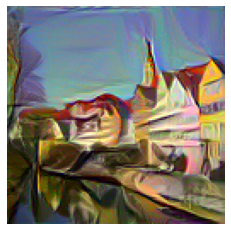

In [71]:
pp_output = tensor_to_image(pp_output)
plt.imshow(pp_output)
plt.axis('off')

### Style Image = Pollock

(-0.5, 127.5, 127.5, -0.5)

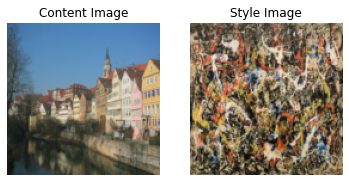

In [72]:
content_tensor = image_loader("images/Tuebingen_Neckarfront.jpg")
style_tensor = image_loader("images/pollock.jpg")

content_img = tensor_to_image(content_tensor)
style_img = tensor_to_image(style_tensor)

input_tensor = content_tensor.clone()

plt.subplot(1,2,1)
plt.imshow(content_img)
plt.title('Content Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(style_img)
plt.title('Style Image')
plt.axis('off')

In [74]:
jp_output = run_style_transfer(network, norm_mean, norm_std, content_tensor, style_tensor,
                           input_tensor, style_layers=style_layers,
                           content_layers=content_layers, style_weight=100000, content_weight=2, num_steps= 3)

<ipython-input-60-21543b6a0e13>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).reshape(-1, 1, 1)
<ipython-input-60-21543b6a0e13>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).reshape(-1, 1, 1)
100%|██████████| 3/3 [00:36<00:00, 12.11s/it]


(-0.5, 127.5, 127.5, -0.5)

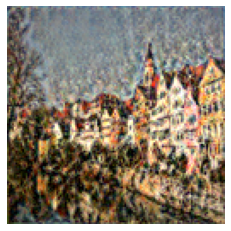

In [75]:
jp_output = tensor_to_image(jp_output)
plt.imshow(jp_output)
plt.axis('off')
# plt.savefig("output_images/pollock_style.png")